In [10]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt

In [11]:
#compute the sharpe ratio
def compute_sharpe(weights, mean_vector, cov_matrix):
    mean = np.dot(weights,mean_vector)
    var = np.dot(np.dot(weights,cov_matrix),weights.T)
    return mean/np.sqrt(var)

In [12]:
#objective function to be minimized
def objective_func(weights, mean_vector, cov_matrix):
    return -compute_sharpe(weights, mean_vector, cov_matrix)

In [13]:
#compute weights to max the sharpe ratio given fixed mean_vector and cov_matrix
def compute_optimal_weights(mean_vector,cov_matrix,starting_weights):
    res = optimize.minimize(objective_func,x0=starting_weights,args=(mean_vector,cov_matrix),method='SLSQP',bounds=24*[(0,None)],constraints={'type':'eq','fun':lambda x: x.sum()-1})
    return res.x

In [14]:
#given past data, calculate the starting weights
def compute_starting_weights(past_prices):
    past_returns = past_prices.pct_change().dropna()

    mean_vector = past_returns.mean(axis=0)
    cov_matrix = past_returns.cov()

    return compute_optimal_weights(mean_vector,cov_matrix,np.repeat(1/24,24))

In [15]:
#the actual thing I need to work on
def allocate_portfolio(new_prices):
    global past_prices
    past_prices = past_prices.append(new_prices)
    past_returns = past_prices.pct_change().dropna()
    past_prices = past_prices[1:]
    #compute the mean_vector and cov_matrix
    mean_vector = past_returns.mean(axis=0)
    cov_matrix = past_returns.cov()
    
    global current_weight
    res = compute_optimal_weights(mean_vector,cov_matrix,current_weight)
    current_weight = res
    return res

In [16]:
def backtester(future_prices):
    '''
    given a dataframe of future prices, compute the sharpe ratio over that interval
    Input:
        - future_prices: a dataframe of future prices
    Output:
        - sharpe ratio over the period covered in future_prices using the allocate_portfolio function
    '''
    #obtain list of time periods
    time_steps = future_prices.index

    #copy the table
    res = future_prices.copy(deep=True)
    res.columns = [asset for asset in future_prices.columns]

    #add columns for weights to the table
    temp = pd.DataFrame()
    
    for time_step in time_steps:
        future_price = res.loc[time_step]
        temp = temp.append(pd.Series(allocate_portfolio(future_price)),ignore_index=True)

    temp.columns = [asset+' Weight' for asset in future_prices.columns]
    temp.index = time_steps
    res = pd.merge(res,temp,left_index=True, right_index=True)

    #compute PnL & Value held for each asset
    for asset in future_prices.columns:
        transaction_cost = (res[asset+' Weight']-res[asset+' Weight'].shift()).abs()*res[asset]*0.003
        res[asset+' PnL'] = (res[asset]-res[asset].shift())*res[asset].shift() - transaction_cost
        res[asset+' Value'] = res[asset+' Weight']*res[asset]

    #compute Portfolio PnL
    res['Total PnL'] = res[[column for column in res.columns if 'PnL' in column]].sum(axis=1)

    #compute Portfolio Value
    res['Total Value'] = res[[column for column in res.columns if 'Value' in column]].sum(axis=1)

    #compute Returns
    res['Returns'] = res['Total PnL']/res['Total Value'].shift()

    #compute Sharpe
    return res['Returns'].dropna().mean()/res['Returns'].dropna().std()

In [25]:
#training and testing sets
training_prices = pd.read_csv('Case3HistoricalPrices.csv',index_col=0)[:1900]
testing_prices_1 = pd.read_csv('Case3HistoricalPrices.csv',index_col=0)[1900:2000]
testing_prices_2 = pd.read_csv('Case3HistoricalPrices.csv',index_col=0)[2000:]

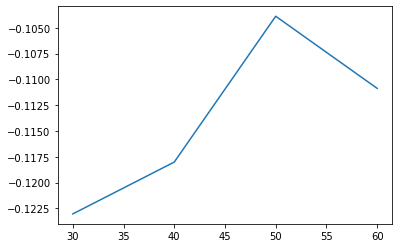

In [26]:
res = []
for lookback_period in range(30,70,10):
    past_prices = training_prices[-lookback_period:]
    current_weight = compute_starting_weights(past_prices)
    res.append(backtester(testing_prices_1))
plt.plot(list(range(30,70,10)),res)

In [27]:
lookback_period = 50
past_prices = testing_prices_1[-lookback_period:]
current_weight = compute_starting_weights(past_prices)

In [10]:
sharpe = backtester(testing_prices_2)
sharpe

0.03297239189997865